In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [12]:
limitTrees =OrderedDict()
dataCards = OrderedDict()

limitTrees_obs =OrderedDict()
dataCards_obs = OrderedDict()
limitTrees_hybridNew = OrderedDict()

version = '/V1p17/v2/v106/'



dc_version = 'v12'
dc_version = 'v13'

nrechit = 130
dphi = 'dPhiCluster0p75'

mode = 'allProd_withggZH'
decay = '4Tau'
decay = 'dddd'
# decay = 'bbbb'



methodA = False
# unblind = 'unblindABC'
unblind = 'unblind'
hybridNew = 1

bdt_name = 'cut_based_v4'
limitDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
dataCardDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'
hybridNewDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/hybridNew/'+version+'/'+bdt_name+'/'+dc_version+'/'

# limitDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/combined_limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
# dataCardDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/combined_datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'


if methodA:
    limitDir+='methodA/'
    dataCardDir+='methodA/'
    hybridNewDir+='methodA/'
else:
    limitDir+='methodB/'
    dataCardDir+='methodB/'
    if hybridNew: hybridNewDir+='methodB/'
lumi = 137000

ctaus = np.array([10, 20, 30, 40, 50, 60, 100, 125, 200, 300, 500, 600,700,800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 20000, 30000, 100000,int(2e5),int(3e5),\
                        int(2e6),int(3e6),int(5e6),int(1e7)]) #v12



if decay == 'bbbb': mass = np.array([ 15, 40, 55])
else:mass = np.array([ 7, 15, 40, 55])

### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']


for m in mass:
    limitTrees[m] = {}
    dataCards[m] = {}
    limitTrees_hybridNew[m] = {}
    for ct in ctaus:
        name = mode+'_HToSSTo'+decay
        dataCards[m][ct] = dataCardDir + '/'+unblind+'/'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.txt'
        if unblind=='unblind':limitTrees[m][ct] = limitDir + '/'+unblind+'/obs/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.AsymptoticLimits.mH120.root'
        else:limitTrees[m][ct] = limitDir + '/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.AsymptoticLimits.mH120.root'
        if hybridNew:
            limitTrees[m][ct] = []
            for i in range(6):
#                 if i==5:limitTrees[m][ct].append(hybridNewDir +'/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.HybridNew.mH120.root')
#                 else:limitTrees[m][ct].append(hybridNewDir +'/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.T2000.HybridNew.mH120.quant'+expected[i]+'.root')
                if i == 5:limitTrees[m][ct].append(hybridNewDir +'/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.T2000.HybridNew.mH120.root')
                else:limitTrees[m][ct].append(hybridNewDir +'/'+unblind+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.T2000.HybridNew.mH120.quant'+expected[i]+'.root')


norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    limits[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees[m].keys()):
        if not os.path.isfile(dataCards[m][k]):continue
        line = open(dataCards[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if hybridNew:
            for n in range(6):
#                 if n == 0 or n == 4:continue
#                 if n == 0 or n == 4 or n == 1:continue
                if len(uproot.open(limitTrees[m][k][n]).keys()) == 2:
                    T = uproot.open(limitTrees[m][k][n])['limit']
                    if len(np.array(T.array('limit'))>0):limits[m][j][n] = np.array(T.array('limit'))/signal_norm
                
        else:
            if len(uproot.open(limitTrees[m][k]).keys()) == 2:
                T = uproot.open(limitTrees[m][k])['limit']
                limits[m][j] = np.array(T.array('limit'))/signal_norm
    limits[m] = np.array(limits[m])

print(ctaus)
print()



[      10       20       30       40       50       60      100      125
      200      300      500      600      700      800     1000     2000
     3000     4000     5000     6000     7000     8000    10000    20000
    30000   100000   200000   300000  2000000  3000000  5000000 10000000]



In [5]:
for k, v in limits.items():
    ctau = np.logical_or(np.logical_or(np.logical_or(ctaus==100, ctaus==1000), ctaus==10000), ctaus==100000)
    print(observed[k]/v[ctau][:, 5])
    print(expected[k]/v[ctau][:, 2])
#     print(v[ctau][:, 5])


#     print(observed[k]/v[ctau][:,5])

    

[0.72523395 0.71885671 0.64276107 0.67016089]
[0.61985903 0.6342583  0.58000818 0.55983286]
[0.72254885 0.7123555  0.76796009 0.71823883]
[0.64050247 0.62687888 0.62222055 0.63694104]
[1.         0.72331873 0.73111226 0.74415706]
[1.         0.61913504 0.6317034  0.64675059]


In [4]:
observed = {15:[0.00475419, 0.00148369, 0.00725514, 0.07311618],
40:[0.205016  , 0.00171665, 0.00210452, 0.01610107],
55:[1.00000000e+06 ,4.10765856e-03 ,1.60033930e-03, 1.08312899e-02]}


expected = {15:[0.00315619, 0.0009883,  0.00484396, 0.04845686],
40:[0.13467661, 0.00114163, 0.00140127, 0.01069139],
55:[1.00000000e+06, 2.73005596e-03 ,1.06512309e-03, 7.19877777e-03]}

In [65]:
# save observed limits for reweighting to compare to ATLAS
import pickle



with open(decay+'.pickle', 'wb') as handle:
    pickle.dump(limits, handle, protocol=pickle.HIGHEST_PROTOCOL)


# load other limit

In [11]:
file_dir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'

exo_19_021_bb55 = file_dir + 'exo-19-021_bb_55.csv'
exo_19_021_bb40 = file_dir + 'exo-19-021_bb_40.csv'
exo_19_021_dd55 = file_dir + 'exo-19-021_dd_55.csv'
exo_19_021_dd40 = file_dir + 'exo-19-021_dd_40.csv'
exo_19_021_dd15 = file_dir + 'exo-19-021_dd_15.csv'


# took from paper draft v5
exo_20_003_bb55 = file_dir + 'exo-20-003_bb_55.csv'
exo_20_003_bb40 = file_dir + 'exo-20-003_bb_40.csv'
exo_20_003_bb15 = file_dir + 'exo-20-003_bb_15.csv'
exo_20_003_dd55 = file_dir + 'exo-20-003_dd_55.csv'
exo_20_003_dd40 = file_dir + 'exo-20-003_dd_40.csv'
exo_20_003_dd15 = file_dir + 'exo-20-003_dd_15.csv'


ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
ms_8 = file_dir + 'atlas_mh125_mx8_ms.csv'


other_limits = {}

other_limits['atlas_ms_40'] = np.genfromtxt(ms_40, delimiter=',')
other_limits['atlas_ms_15'] = np.genfromtxt(ms_15, delimiter=',')
other_limits['atlas_ms_8'] = np.genfromtxt(ms_8, delimiter=',')


# 'ms1_40' = np.genfromtxt(ms1_40, delimiter=',')
# 'ms2_40' = np.genfromtxt(ms2_40, delimiter=',')
# 'id55' = np.genfromtxt(id55, delimiter=',')
# 'comb40' = np.genfromtxt(comb40, delimiter=',')
other_limits['exo_19_021_bb55'] = np.genfromtxt(exo_19_021_bb55, delimiter=',')
other_limits['exo_19_021_bb40'] = np.genfromtxt(exo_19_021_bb40, delimiter=',')
other_limits['exo_19_021_dd55'] = np.genfromtxt(exo_19_021_dd55, delimiter=',')
other_limits['exo_19_021_dd40'] = np.genfromtxt(exo_19_021_dd40, delimiter=',')
other_limits['exo_19_021_dd15'] = np.genfromtxt(exo_19_021_dd15, delimiter=',')

# other_limits['exo_20_003_bb55'] = np.genfromtxt(exo_20_003_bb55, delimiter=',')
# other_limits['exo_20_003_bb40'] = np.genfromtxt(exo_20_003_bb40, delimiter=',')
other_limits['exo_20_003_bb15'] = np.genfromtxt(exo_20_003_bb15, delimiter=',')
# other_limits['exo_20_003_dd55'] = np.genfromtxt(exo_20_003_dd55, delimiter=',')
# other_limits['exo_20_003_dd40'] = np.genfromtxt(exo_20_003_dd40, delimiter=',')
# other_limits['exo_20_003_dd15'] = np.genfromtxt(exo_20_003_dd15, delimiter=',')





# Expected Limit only (blinded)

[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 8.00e-02 1.00e-01
 1.25e-01 1.50e-01 2.00e-01 3.00e-01 5.00e-01 1.00e+00 2.00e+00 3.00e+00
 5.00e+00 1.00e+01 2.00e+01 3.00e+01 5.00e+01 1.00e+02 2.00e+02 3.00e+02
 5.00e+02 1.00e+03 2.00e+03 3.00e+03 5.00e+03 1.00e+04]
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v11/unblind/allProd_withggZH_HToSSTobbbb_dPhiCluster0p75_nRechit130_with1sig_expected.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v11/unblind/allProd_withggZH_HToSSTobbbb_dPhiCluster0p75_nRechit130_with1sig_expected.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v11/unblind/allProd_withggZH_HToSSTobbbb_dPhiCluster0p75_nRechit130_with1sig_expected.pdf has been created


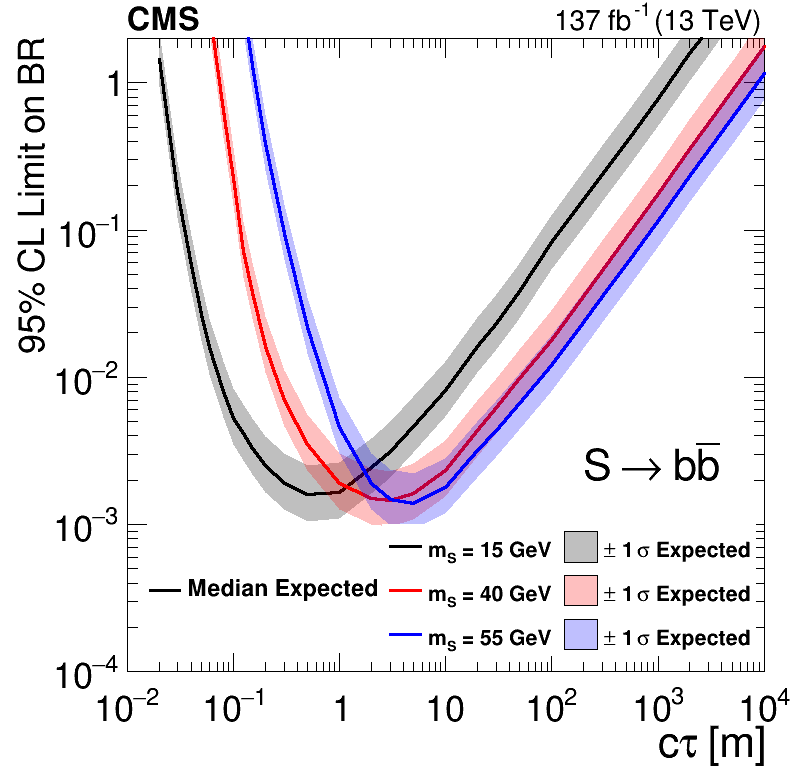

In [15]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])





opac_1sig = 0.25
opac_2sig = 0.1
for band in [0,1,2]:# 0 is no band, 1 is with 1sig only, 2 is with both 1sig and 2sig band
    if not band == 1:continue

    if band ==2: 
        leg = rt.TLegend(0.3,0.75,0.9,0.92)
        leg2 = rt.TLegend(0.1,0.75,0.3,0.90)
    elif band ==1: 
#         leg = rt.TLegend(0.48,0.75,0.95,0.92)
#         leg2 = rt.TLegend(0.18,0.77,0.40,0.90)
        
        leg = rt.TLegend(0.48,0.15,0.95,0.32)
        leg2 = rt.TLegend(0.18,0.17,0.40,0.30)
    else:
        leg = rt.TLegend(0.6,0.7,0.9,0.92)
        leg2 = rt.TLegend(0.2,0.7,0.45,0.92)
    
    
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    leg2.SetTextSize(0.032)
    leg2.SetBorderSize(0)
    leg2.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)


    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
    print(ctaus_m)
    h = {}
    h_exp1sig = {}
    h_exp2sig = {}
    h_obs = {}
    h_others = {}
   
    for i, m in enumerate(mass):
        cond = limits[m][:,2] < 10
        h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limie on BR(h\rightarrow SS)'])
    
        h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
        h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
        
        leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")
        if m == 15:
#             leg2.AddEntry(h_obs[m], "Observed", "LP")
            leg2.AddEntry(h[m], "Median Expected", "L")
            
        if band>0: leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')
        if band==2: leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma Expected", 'F')
        
        if len(mass) == 3: 
            h_exp1sig[m].SetFillColorAlpha(std_color_list[i],opac_1sig)
            h_exp2sig[m].SetFillColorAlpha(std_color_list[i], opac_2sig)
            h[m].SetLineColor(std_color_list[i])
            h[m].SetMarkerColor(std_color_list[i])

        else: 
            if i == 0:
                h_exp1sig[m].SetFillColorAlpha(std_color_list[3], opac_1sig)
                h_exp2sig[m].SetFillColorAlpha(std_color_list[3], opac_2sig)
                h[m].SetLineColor(std_color_list[3])
            else: 
                h_exp1sig[m].SetFillColorAlpha(std_color_list[i-1],opac_1sig)
                h_exp2sig[m].SetFillColorAlpha(std_color_list[i-1], opac_2sig)
                h[m].SetLineColor(std_color_list[i-1])
        h[m].SetLineWidth(3)

        h[m].SetLineStyle(1)
        h[m].SetLineWidth(3)
        h[m].GetXaxis().SetLimits(0.01,10000.0)
        h[m].GetYaxis().SetRangeUser(5e-4,50)
        h[m].GetYaxis().SetRangeUser(1e-4,2)

        h[m].GetXaxis().SetTitleOffset(1)
        h[m].GetYaxis().SetTitleSize(0.05)
        h[m].GetYaxis().SetTitleOffset(1.5)
        
        

    for i,m in enumerate(h.keys()):
        h[m].Draw('LA' if i == 0 else 'Lsame')
#         h_obs[m].Draw('LPsame')
        if band>0: h_exp1sig[m].Draw('Fsame')
        if band==2: h_exp2sig[m].Draw('Fsame')

 

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 0
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 4, iPos)


    if band>0:leg.SetNColumns(2)
    if band == 2:leg.SetNColumns(3)

    leg.Draw()
    leg2.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
    
    latex = rt.TLatex()
    latex.SetTextSize(0.06)
    latex.SetTextFont(42)
        
    if decay == 'dddd': latex.DrawLatex(200,0.002,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(200,0.002, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(200,0.002, "S #rightarrow #tau^{+}#tau^{-}")







    output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)
    if hybridNew:name += '_hybridNew'
    if band==2: name += '_with2sig'
    elif band>0: name += '_with1sig'
    if CMS_lumi.writeExtraText: name += "_pas"


    c.SaveAs(name+'_expected.png')
    c.SaveAs(name+'_expected.C')
    c.SaveAs(name+'_expected.pdf')

    tdrstyle.setTDRStyle()
    c.Draw()
    # print(time.time()-start_t)

# by mass point compare to others

atlas [1.62079267e-01 1.68628206e-01 1.75441759e-01 1.80731994e-01
 1.87105887e-01 1.95632296e-01 2.03536971e-01 2.11761040e-01
 2.21410984e-01 2.31500675e-01 2.39665031e-01 2.48117321e-01
 2.59424019e-01 2.71245962e-01 2.82205867e-01 2.95065978e-01
 3.10043465e-01 3.25781205e-01 3.44016929e-01 3.61479155e-01
 3.77951748e-01 3.99107737e-01 4.23539851e-01 4.47247651e-01
 4.69949847e-01 4.93804401e-01 5.18869808e-01 5.47913737e-01
 5.87241867e-01 6.25045094e-01 6.66820871e-01 7.17994296e-01
 7.53444060e-01 7.94306324e-01 8.59792260e-01 9.26080410e-01
 1.01240643e+00 1.10131296e+00 1.20397356e+00 1.35887943e+00
 1.55092826e+00 1.70271146e+00 1.92707967e+00 2.17292893e+00
 2.55546126e+00 2.96469236e+00 3.49092887e+00 4.01005791e+00
 4.72184807e+00 5.40391980e+00 6.38679562e+00 7.33656319e+00
 8.32160278e+00 9.58542251e+00 1.10186426e+01 1.24617638e+01
 1.41738708e+01 1.58835067e+01 1.81297287e+01 2.03452772e+01
 2.26866927e+01 2.56761438e+01 3.02836311e+01 3.27082831e+01
 3.57179145e+01 4.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


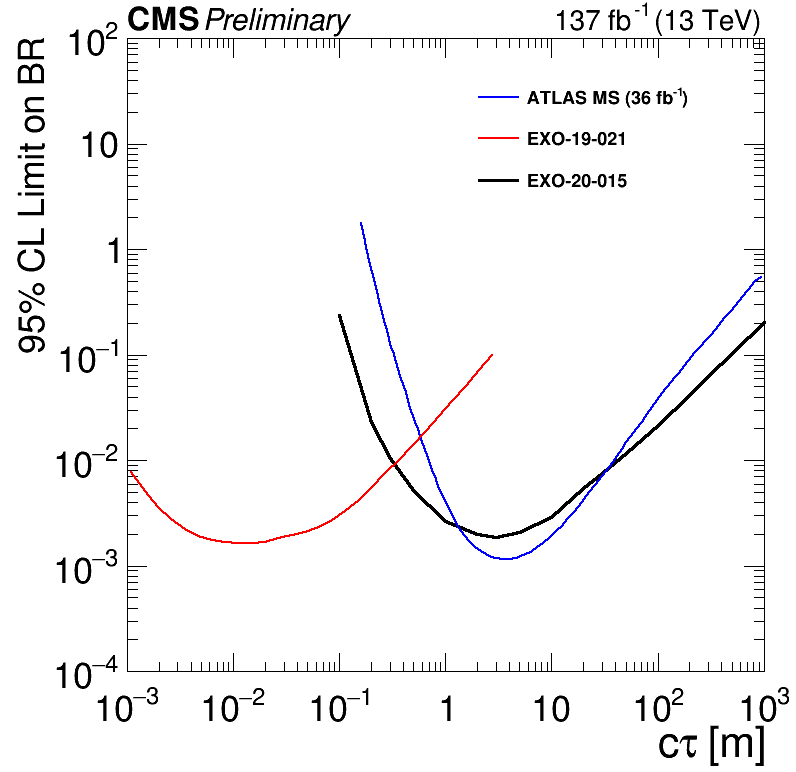

In [19]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withdisplacedJet = 1
observed = 1
withATLAS = 1
scaleATLAS = 0

for m in [7,15,40,55]:
    if m == 7 and decay == 'bbbb':continue
    if not m == 40:continue
    leg = rt.TLegend(0.59,0.74,0.88,0.9)
    if m == 7:leg = rt.TLegend(0.4,0.75,0.9,0.85)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)


    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
    h_others = {}
    h = {}
    h_exp1sig = {}
    h_exp2sig = {}
    h_mark = {}

    for k, v in other_limits.items():
        if not str(m) in k and not (m==7 and '8' in k): continue
        if not decay[:2] in k and not 'atlas' in k:continue
        if not withATLAS and 'atlas' in k:continue
        if scaleATLAS == 1 and 'atlas' in k:    
            h_others[k] = create_TGraph(v[:,0],v[:,1]/(137/36.1)**0.5,  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        else:
            h_others[k] = create_TGraph(v[:,0],v[:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
            if 'atlas' in k:print('atlas',v[:,0],v[:,1])


    for i,k in enumerate(h_others.keys()):

        if 'exo_19_021' in k: leg.AddEntry(h_others[k], "EXO-19-021", 'L')
        elif withATLAS and 'atlas' in k and scaleATLAS and m == 7:leg.AddEntry(h_others[k], "ATLAS MS (scaled by 1.9),  m_{x} = 8 GeV", 'L')
        elif withATLAS and 'atlas' in k and not scaleATLAS and m == 7:leg.AddEntry(h_others[k], "ATLAS MS (36 fb^{-1}),  m_{x} = 8 GeV", 'L')
        elif withATLAS and 'atlas' in k and scaleATLAS:leg.AddEntry(h_others[k], "ATLAS MS (scaled by 1.9)", 'L')
        elif withATLAS and 'atlas' in k and not scaleATLAS:leg.AddEntry(h_others[k], "ATLAS MS (36 fb^{-1})", 'L')
        elif '20_003' in k: leg.AddEntry(h_others[k], "EXO-20-003", 'L')

        if 'exo_19_021' in k: h_others[k].SetLineColor(std_color_list[1])
        elif withATLAS and 'atlas' in k : h_others[k].SetLineColor(std_color_list[2])
        elif '20_003' in k:  h_others[k].SetLineColor(std_color_list[3])
    
    
    cond = limits[m][:,2] < 1
    if scaleATLAS:  
        if observed: h[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond]/2**0.5,  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        else:h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond]/2**0.5,  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        if m == 7:leg.AddEntry(h[m], "EXO-20-015,  m_{x} = 7 GeV (scaled by #sqrt{2})", "L")
        else:leg.AddEntry(h[m], "EXO-20-015 (scaled by #sqrt{2})", "L")
    else: 
        if observed: h[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        else:h[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
        if m == 7:leg.AddEntry(h[m], "EXO-20-015,  m_{x} = 7 GeV", "L")
        else:leg.AddEntry(h[m], "EXO-20-015", "L")
            
        print(ctaus_m[cond], limits[m][:,5][cond])


    h[m].SetLineColor(std_color_list[0])
    h[m].SetLineWidth(3)
    if m == 7:h[m].GetXaxis().SetLimits(0.01,1000.0)
    else:h[m].GetXaxis().SetLimits(0.001,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,100)
    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)
    h[m].Draw('LA')


    for i, k in enumerate(h_others.keys()): 
        h_others[k].SetLineWidth(2)
        h_others[k].Draw('Lsame')



    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 4, iPos)


    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)+'_mass'+str(m)+'_compare'
    if observed: name += '_observed'
    else: name += '_expected'
    if withATLAS: name+='_withATLAS'
    if withATLAS and scaleATLAS: name+='_scaledATLAS'
    print(name)

#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')

    tdrstyle.setTDRStyle()
    c.Draw()
    # print(time.time()-start_t)

# comparison with ALTAS (all masses)

[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 1.00e-01 1.25e-01
 2.00e-01 3.00e-01 5.00e-01 1.00e+00 2.00e+00 3.00e+00 5.00e+00 1.00e+01
 2.00e+01 3.00e+01 5.00e+01 1.00e+02 2.00e+02 3.00e+02 5.00e+02 2.00e+03
 3.00e+03 5.00e+03 1.00e+04]
[1.64293274e+00 7.40615243e-02 2.24172159e-02 1.03251048e-02
 7.78682162e-03 6.15564239e-03 3.79885011e-03 3.28867754e-03
 3.12748747e-03 3.15188254e-03 3.48426435e-03 4.84195866e-03
 1.05398805e-02 1.53290879e-02 2.49556759e-02 4.02231129e-02
 8.64548803e-02 1.29015818e-01 2.16607481e-01 4.90720985e-01
 9.89020722e-01 1.42625703e+00 2.44730515e+00 9.88262575e+00
 1.48374416e+01 2.49815482e+01 4.94838430e+01]
[1.66156234e+02 2.11394320e+00 2.92750342e-01 8.60138456e-02
 4.07280865e-02 2.61499038e-02 8.74400635e-03 6.59163353e-03
 3.93487028e-03 2.94255719e-03 2.94957307e-03 3.30137654e-03
 5.00057811e-03 7.17208026e-03 1.03052408e-02 1.88311577e-02
 4.08315873e-02 6.15877395e-02 1.05982965e-01 2.19126878e-01
 4.23132498e-01 6.38920846e-01 1.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v12/unblind/allProd_withggZH_HToSSTo4Tau_dPhiCluster0p75_nRechit130_observed_withATLAS_hybridNew.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v12/unblind/allProd_withggZH_HToSSTo4Tau_dPhiCluster0p75_nRechit130_observed_withATLAS_hybridNew.C has been generated
Info in <TCanvas::Print>: pdf file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v12/unblind/allProd_withggZH_HToSSTo4Tau_dPhiCluster0p75_nRechit130_observed_withATLAS_hybridNew.pdf has been created


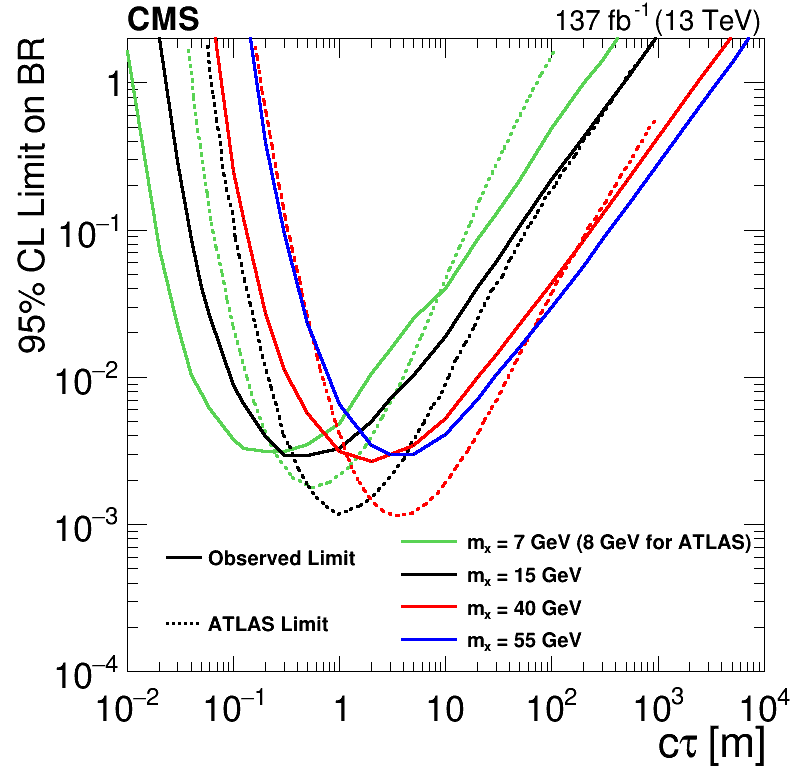

In [68]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   


if decay == 'bbbb':
    leg = rt.TLegend(0.55,0.15,0.88,0.32)
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)
else:
    leg = rt.TLegend(0.49,0.15,0.88,0.32)
    
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)

leg2 = rt.TLegend(0.2,0.15,0.45,0.32)
leg2.SetTextSize(0.028)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
print(ctaus_m)
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
h_others = {}
upper = 1000000

if withATLAS:
    
    if not 'b' in decay: h_others[7] = create_TGraph(other_limits['atlas_ms_8'][:,0][other_limits['atlas_ms_8'][:,1]<upper],other_limits['atlas_ms_8'][:,1][other_limits['atlas_ms_8'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_others[15] = create_TGraph(other_limits['atlas_ms_15'][:,0][other_limits['atlas_ms_15'][:,1]<upper],other_limits['atlas_ms_15'][:,1][other_limits['atlas_ms_15'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_others[40] = create_TGraph(other_limits['atlas_ms_40'][:,0][other_limits['atlas_ms_40'][:,1]<upper],other_limits['atlas_ms_40'][:,1][other_limits['atlas_ms_40'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#         for k, v in h_others.items():
#             leg.AddEntry(h_others[k], "ATLAS MS (36 fb^{-1})", 'L')


for i, m in enumerate(mass):
    cond = limits[m][:,5] < upper
#     if m == 7 and decay == '4Tau':  
#         cond = np.logical_and(cond, np.logical_not(ctaus_m==5))
#         cond = np.logical_and(cond, np.logical_not(ctaus_m==3))
#         cond = np.logical_and(cond, np.logical_not(ctaus_m==2))
    h_obs[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#     print(m)
#     print(ctaus_m[cond])
    print(limits[m][:,5][cond])
    if m == 7:leg.AddEntry(h_obs[m], "m_{x} = "+str(m)+" GeV (8 GeV for ATLAS)", "L")
    else: leg.AddEntry(h_obs[m], "m_{x} = "+str(m)+" GeV", "L")
    if m == 15:
        leg2.AddEntry(h_obs[m], "Observed Limit", "LP")
        leg2.AddEntry(h_others[m], "ATLAS Limit", "L")


    if len(mass) == 3: 
        if not m == 55:h_others[m].SetLineColor(std_color_list[i])
        h_obs[m].SetLineColor(std_color_list[i])
#         h_obs[m].SetMarkerColor(std_color_list[i])


    else: 
        if i == 0:
            h_others[m].SetLineColor(std_color_list[3])
            h_obs[m].SetLineColor(std_color_list[3])
            h_obs[m].SetMarkerColor(std_color_list[3])
        else: 
            if not m == 55:h_others[m].SetLineColor(std_color_list[i-1])
            h_obs[m].SetLineColor(std_color_list[i-1])
#             h_obs[m].SetMarkerColor(std_color_list[i-1])
    h_obs[m].SetLineWidth(3)
#     h_obs[m].SetMarkerStyle(20)
#     h_obs[m].SetMarkerSize(1)
    if not m == 55:
        h_others[m].SetLineStyle(2)
        h_others[m].SetLineWidth(3)
        h_others[m].GetXaxis().SetLimits(0.01,10000.0)
#         h_others[m].GetYaxis().SetRangeUser(5e-4,100)
        h_others[m].GetYaxis().SetRangeUser(1e-4,2)


        h_others[m].GetXaxis().SetTitleOffset(1)
        h_others[m].GetYaxis().SetTitleSize(0.05)
        h_others[m].GetYaxis().SetTitleOffset(1.5)



for i,m in enumerate(h_obs.keys()):
    if not m == 55:
        h_others[m].Draw('LA' if i == 0 else 'Lsame')
    h_obs[m].Draw('LPsame')



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText =0
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
CMS_lumi.CMS_lumi(c, 4, iPos)

leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)+'_observed_withATLAS'
if hybridNew:name += '_hybridNew'
if CMS_lumi.writeExtraText: name += "_pas"



c.SaveAs(name+'.png')
c.SaveAs(name+'.C')
c.SaveAs(name+'.pdf')

tdrstyle.setTDRStyle()
c.Draw()


# Observed Limit

[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 1.00e-01 1.25e-01
 2.00e-01 3.00e-01 5.00e-01 6.00e-01 7.00e-01 8.00e-01 1.00e+00 2.00e+00
 3.00e+00 4.00e+00 5.00e+00 6.00e+00 7.00e+00 8.00e+00 1.00e+01 2.00e+01
 3.00e+01 1.00e+02 2.00e+02 3.00e+02 2.00e+03 3.00e+03 5.00e+03 1.00e+04]
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v13/unblind/allProd_withggZH_HToSSTodddd_dPhiCluster0p75_nRechit130_hybridNew_with1sig.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v13/unblind/allProd_withggZH_HToSSTodddd_dPhiCluster0p75_nRechit130_hybridNew_with1sig.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v106/cut_based_v4/v13/unblind/allProd_withggZH_HToSSTodddd_dPhiCluster0p75_nRechit130_hybridNew_with1sig.pdf has been created


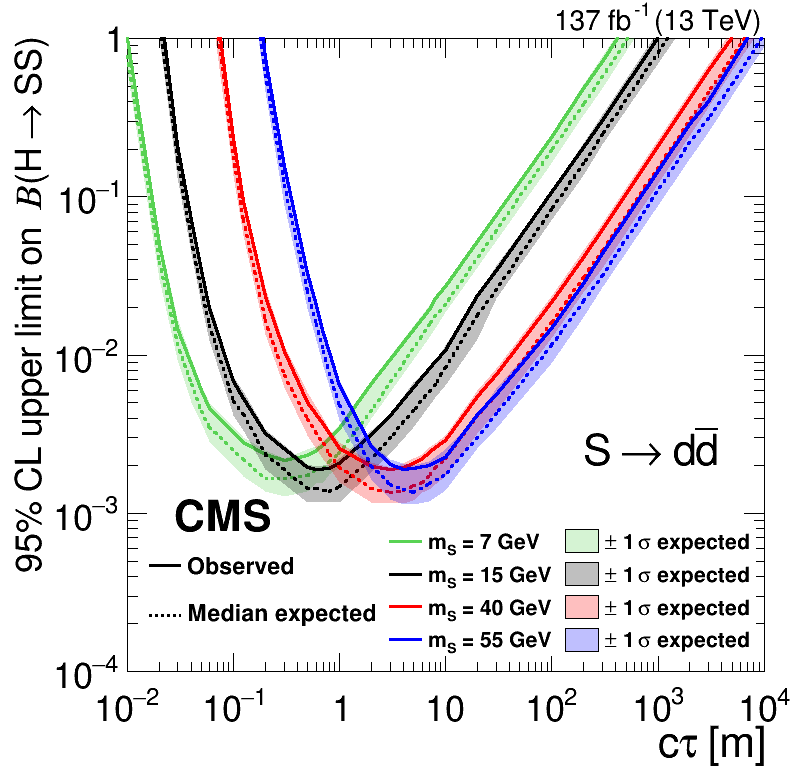

In [13]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])





opac_1sig = 0.25
opac_2sig = 0.15
for band in [0,1,2]:# 0 is no band, 1 is with 1sig only, 2 is with both 1sig and 2sig band
    if not band == 1:continue

    if band ==2: 
        leg = rt.TLegend(0.3,0.75,0.9,0.92)
        leg2 = rt.TLegend(0.1,0.75,0.3,0.90)
    elif band ==1: 
#         leg = rt.TLegend(0.48,0.75,0.95,0.92)
#         leg2 = rt.TLegend(0.18,0.77,0.40,0.90)
        
        leg = rt.TLegend(0.48,0.15,0.95,0.32)
        leg2 = rt.TLegend(0.18,0.17,0.40,0.30)
    else:
        leg = rt.TLegend(0.6,0.7,0.9,0.92)
        leg2 = rt.TLegend(0.2,0.7,0.45,0.92)
    
    
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    leg2.SetTextSize(0.032)
    leg2.SetBorderSize(0)
    leg2.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)


    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
    print(ctaus_m)
    h = {}
    h_exp1sig = {}
    h_exp2sig = {}
    h_obs = {}
    h_others = {}
   
    for i, m in enumerate(mass):
        cond = limits[m][:,2] < 50
        cond = np.logical_and(cond, limits[m][:,0] < 50)
        cond = np.logical_and(cond, limits[m][:,1] < 50)
        cond = np.logical_and(cond, limits[m][:,3] < 50)




#         if not m == 7:continue
        if decay == 'dddd':
            if m == 7:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==5))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==3))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.1))


                cond = np.logical_and(cond, np.logical_not(ctaus_m==30))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==20))



            if m == 15:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.7))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.3))
            if m == 40:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.6))


            if m == 55:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==8))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==6))


        if decay == '4Tau':
            if m == 7:
#                 cond = np.logical_and(cond, np.logical_not(ctaus_m==0.1))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.06))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.2))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.125))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.8))







                cond = np.logical_and(cond, np.logical_not(ctaus_m==2))
#                 cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==10))
            if m == 15:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.8))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.6))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==5))

#                 cond = np.logical_and(cond, np.logical_not(ctaus_m==8))

                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==10))




            if m == 40:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))



            if m == 55:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==5))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==8))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))




                
        if decay == 'bbbb':
            if m == 15:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.5))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==8))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.8))



            if m == 40:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==0.5))

                cond = np.logical_and(cond, np.logical_not(ctaus_m==5))

                cond = np.logical_and(cond, np.logical_not(ctaus_m==10))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
                
            if m == 55:
                cond = np.logical_and(cond, np.logical_not(ctaus_m==5))
                cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
#                 cond = np.logical_and(cond, np.logical_not(ctaus_m==2))





#         h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on B(H  #rightarrow SS)'])
#         h_obs[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL upper limit on B(H #rightarrow SS)'])
    
        h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on  #bf{#it{#Beta}}(H #rightarrow SS)'])
        h_obs[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL upper limit on #bf{#it{#Beta}}(H #rightarrow SS)'])
    
    
    

        h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
        h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
        
        leg.AddEntry(h_obs[m], "m_{S} = "+str(m)+" GeV", "L")
        if m == 15:
            leg2.AddEntry(h_obs[m], "Observed", "LP")
            leg2.AddEntry(h[m], "Median expected", "L")
            



        if band>0: leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma expected", 'F')
        if band==2: leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma expected", 'F')
        
        if len(mass) == 3: 
            h_exp1sig[m].SetFillColorAlpha(std_color_list[i],opac_1sig)
            h_exp2sig[m].SetFillColorAlpha(std_color_list[i], opac_2sig)
            h[m].SetLineColor(std_color_list[i])
            h_obs[m].SetLineColor(std_color_list[i])
            h_obs[m].SetMarkerColor(std_color_list[i])


        else: 
            if i == 0:
                h_exp1sig[m].SetFillColorAlpha(std_color_list[3], opac_1sig)
                h_exp2sig[m].SetFillColorAlpha(std_color_list[3], opac_2sig)
                h[m].SetLineColor(std_color_list[3])
                h_obs[m].SetLineColor(std_color_list[3])
                h_obs[m].SetMarkerColor(std_color_list[3])
            else: 
                h_exp1sig[m].SetFillColorAlpha(std_color_list[i-1],opac_1sig)
                h_exp2sig[m].SetFillColorAlpha(std_color_list[i-1], opac_2sig)
                h[m].SetLineColor(std_color_list[i-1])
                h_obs[m].SetLineColor(std_color_list[i-1])
                h_obs[m].SetMarkerColor(std_color_list[i-1])
        h_obs[m].SetLineWidth(3)
#         h_obs[m].SetMarkerStyle(20)
#         h_obs[m].SetMarkerSize(1)

        h[m].SetLineStyle(2)
        h[m].SetLineWidth(3)
        h[m].GetXaxis().SetLimits(0.01,10000.0)
        h[m].GetYaxis().SetRangeUser(5e-4,50)
        h[m].GetYaxis().SetRangeUser(1e-4,1)

        h[m].GetXaxis().SetTitleOffset(1)
        h[m].GetYaxis().SetTitleSize(0.05)
        h[m].GetYaxis().SetTitleOffset(1.5)
#         h[m].SetTitle('95% CL upper limit on B(H #rightarrow SS)')
#         graph->SetTitle("global title;X axis title;Y axis title;Z axis title");




        ###### save to text file for hepdata ######
        outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/'+dc_version+'/'
#         if not os.path.isdir(outputDir):os.makedirs(outputDir)
#         outputFileName = outputDir + 'limits'+decay+'_m'+str(m)
#         if hybridNew: outputFileName += '_hybridNew'
#         outputFileName += '.txt'
#         np.savetxt(outputFileName, np.column_stack((ctaus_m[cond], limits[m][cond])), delimiter="\t")

        ###### save to ROOT file ######
#         outFile = rt.TFile(outputDir+'limits.root', 'UPDATE')
#         name = ['n2sig', 'n1sig', 'exp', 'p1sig', 'p2sig','obs']
#         outFile.WriteTObject(h[m], 'h_'+decay+'_m'+str(m)+'_exp', "WriteDelete");
#         outFile.WriteTObject(h_obs[m], 'h_'+decay+'_m'+str(m)+'_obs', "WriteDelete");


    
#         outFile.Close();
        

    for i,m in enumerate(h.keys()):
        h[m].Draw('LA' if i == 0 else 'Lsame')
        h_obs[m].Draw('LPsame')
        if band>0: h_exp1sig[m].Draw('Fsame')
        if band==2: h_exp2sig[m].Draw('Fsame')

    leg.Draw()
    leg2.Draw()

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    
    CMS_lumi.writeExtraText = 0
    CMS_lumi.extraText   = "Supplementary"
    CMS_lumi.extraText   = "Preliminary"
    CMS_lumi.cmsTextSize      = 1.2
    
    
    
    if (CMS_lumi.writeExtraText == 0): 
        iPos = 11
        CMS_lumi.relPosX = 0.15
        CMS_lumi.relPosY = 0.73
    else:
        iPos = 0
        CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, iPos)


    if band>0:leg.SetNColumns(2)
    if band == 2:leg.SetNColumns(3)

    
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
    
    latex = rt.TLatex()
    latex.SetTextSize(0.06)
    latex.SetTextFont(42)
        
    if decay == 'dddd': latex.DrawLatex(200,0.002,  "S #rightarrow d#bar{d}")
    elif decay == 'bbbb': latex.DrawLatex(200,0.002, "S #rightarrow b#bar{b}")
    elif decay == '4Tau': latex.DrawLatex(200,0.002, "S #rightarrow #tau^{+}#tau^{-}")





    ###### save plot #####

    output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)
    if hybridNew:name += '_hybridNew'
    if band==2: name += '_with2sig'
    elif band>0: name += '_with1sig'
    if CMS_lumi.writeExtraText and CMS_lumi.extraText == 'Preliminary': name += "_pas"
    if CMS_lumi.writeExtraText and CMS_lumi.extraText == 'Supplementary': name += "_supplementary"


    c.SaveAs(name+'.png')
    c.SaveAs(name+'.C')
    c.SaveAs(name+'.pdf')


    c.Draw()
    
    


    # print(time.time()-start_t)

# limit for different mass points

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot



# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
ctaus_m = ctaus/1000
print(ctaus_m)
# print(limits[:,2])
h_others = {}
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
for m in mass:
#     if not m == 15:continue
    print(m)
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    if drawObs: h_obs[m] = create_TGraph(ctaus_m[cond], limits_obs[m][:,5][cond])


    h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
    h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
#
    leg.AddEntry(h[m], "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_obs[m], "Observed", "PL")
    leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma Expected", 'F')
    h[m].SetLineColor(std_color_list[2])
    h[m].SetLineWidth(2)
    h[m].SetLineStyle(4)


    
    h_obs[m].SetMarkerStyle(8)
    h_obs[m].SetMarkerSize(1)
    h_obs[m].SetLineColor(1)
    h_obs[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
    h[m].GetXaxis().SetLimits(0.01,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,100)
    h[m].GetXaxis().SetTitleOffset(1)

    h[m].Draw('LA')
    h_exp2sig[m].Draw( 'Fsame')
    h_exp1sig[m].Draw('Fsame')
    h[m].Draw('Lsame')
    h_obs[m].Draw('PLsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"
    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    c.Draw()
    output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/unblind/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    if VBFH:
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')
    else:
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')

# limit for different nrechits

##### load ntuples

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v66/'
bdt_name = 'cut_based_v4'
dc_version = 'v7'
methodA = True
dphi = 'dPhiCluster0p75'
# dphi = 'dPhiJet0p6'
nRechit = 'nRechit130'
# NEW_CTAU = 60 #cm
limitDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
dataCardDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'
method = 1
fit_function = 'methodB/blind/'
nRechits = np.arange(60,220,10)
nRechits = np.arange(60,180,10)
nRechits = [60,70,80,90,100,120,130,135,140,145,150,155,160,170]

# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
var = nRechits


limits = np.ones((len(masses),len(nRechits), 6))



limitDir = limitDir0 +fit_function+'/'
dataCardDir = dataCardDir0 + fit_function+'/'
for i, m in enumerate(masses):
    for j,nRechit in enumerate(var):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.txt'

    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
  
    print(nRechits)


#### plot limit vs. nrechit

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.25,0.75,0.55,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)



c = rt.TCanvas('c','c', 900, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
h = {}
h_exp2sig = {}
h_exp1sig = {}

# for i, m in enumerate(masses):
legend = {}
legend[0] = 'scaled from intime low BDT, ABCD method'
legend[1] = 'scaled from OOT high BDT, ABCD method'
legend[2] = 'scaled from OOT high BDT, single expo'
legend[3] = 'scaled from OOT high BDT, modified expo'
legend[4] = 'scaled from OOT high BDT, single power law'





for i, m in enumerate(masses):
    
   
    h[m] = create_TGraph(var, limits[i,:,2],  axis_title=['N_{rechits} cut', '95% CL Limit on BR'])
    h_exp1sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,1], np.flip(limits[i,:,3]))))
    h_exp2sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,0], np.flip(limits[i,:,4]))))

    leg.AddEntry(h[m], "m_{x} = "+str(m)+" GeV, c#tau = "+str(int(ct/1000))+" m", "L")


#     leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
#     leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')

#     h_exp1sig.SetFillColor(std_color_list[3])
#     h_exp2sig.SetFillColor(5)
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
  
    
    h[m].Draw('ac' if i == 0 else 'c')
#     if m == 55:
#         h_exp2sig[m].Draw( 'Fsame')
#         h_exp1sig[m].Draw('Fsame')
    h[m].Draw('LSame')


# #     h[m].GetXaxis().SetLimits(0.5,1)
    h[m].GetXaxis().SetLimits(50,200)
    h[m].GetYaxis().SetRangeUser(1e-4,1)
#     h[m].GetXaxis().SetTitleOffset(1)

#     h_exp2sig.Draw('Fsame')
#     h_exp1sig.Draw('Fsame')
#     h.Draw('Lsame')

#     result = nRechits[np.where(limits[i,:,2] == np.amin(limits[i,:,2]))]
#     print("nRechits cut with minimum limit: ", result)




leg.Draw()
c.SetRightMargin(0.1)
c.SetLogy()
# c.SetLogx()

c.Draw()
output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'
c.SaveAs(output_dir+'/ggh_bbbb_scanNrechits.png')
# print(time.time()-start_t)

# limit wrt Nrechits for different methods

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v2/'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'
methodA = True
dphi = 'dPhiCluster0p75'
nRechit = 'nRechit100'
# NEW_CTAU = 60 #cm
limitDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'
dataCardDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'
method = 1
fit_function = 'se'
if method == 0:
    limitDir+='methodA/'
    dataCardDir+='methodA/'
elif method == 1:
    limitDir+='methodB/'
    dataCardDir+='methodB/'
else:
    limitDir+='methodC_'+fit_function+'/'
    dataCardDir+='methodC_'+fit_function+'/'
nRechits = np.arange(60,220,10)
# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
m = 40
var = nRechits
# limits = np.ones((len(masses),len(var), 6))
limits = np.ones((len(masses),len(nRechits), 6))


for i, m in enumerate(masses):


    for j,nRechit in enumerate(nRechits):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.txt'
#     for j,k in enumerate(dphis):
#         dphi = str(k).replace('.','p')
#         limitTrees[k] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.AsymptoticLimits.mH120.root'
#         dataCards[k] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.txt'


        
    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
#         print(m,k,limits[i,j,2])
#         print(i,j, limits[i,j])
#         if i == 0: limits[i] = np.array(T.array('limit'))/signal_norm
#         else: limits[i] = np.vstack((limits[i], T.array('limit')/signal_norm))
    #     print("signal_norm",signal_norm)
#     limits = np.array(limits)
#     print(str([round(i, 5) for i in limits[:,2]])[1:-1])
    
#     result = nRechits[np.where(limits[:,2] == np.amin(limits[:,2]))]
#     print(NEW_CTAU, "nRechits cut with minimum limit: ", result)
#[0.00941727 0.00232179 0.00032019 0.0002337  0.00017991 0.00017472]
# print(limits.shape)
print(nRechits)
for i in limits[:,:,2]:
    print(str([round(j,5) for j in i])[1:-1])


